In [8]:
import torch
import torchaudio
from torch.utils.data import Dataset
import librosa
from scipy.signal import butter, lfilter


class SpeechDataset(Dataset):
    def __init__(self, ):
        super().__init__()
        self.noise_file_path =  "/Users/rockwell/Documents/python/SE-with-SubSampler/data/source/urban/0_air_conditioner/13230-0-0-1.wav"
        self.clean_file_path = (
             "/Users/rockwell/Documents/python/SE-with-SubSampler/data/source/clean/p226_001.wav"
        )
        self.snr_level = 5
        self.max_len = 65280
        self.sr = 48000
        self.batch_size =1
        self.cut_off = self.sr / 4
        self.cur_order = 5
        self.noise_type = "0_air_conditioner"

    def __len__(self):
        return self.batch_size

    def load_sample(self, file):
        waveform, osr = torchaudio.load(file)
        # サンプリングレートが指定されている場合はリサンプリング
        if self.sr != osr:
            wav = librosa.resample(y=waveform.cpu().detach().numpy(), orig_sr=osr, target_sr=self.sr)
            wav = torch.tensor(wav)
        # モノラルに変換
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

    def __getitem__(self, index):
        clean = self.load_sample(self.clean_file_path)
        noise = None
        if self.noise_type != "white":
            noise = self.load_sample(self.noise_file_path)

        # サンプルの整形
        clean = self._prepare_sample(clean)
        noisy = None
        if self.noise_type == "white":
            noisy = self.add_white_noise(clean, self.snr_level)
        else:
            noisy = self.add_noise(clean, noise, self.snr_level)

        return noisy, clean

    def _prepare_sample(self, waveform):
        channels, current_len = waveform.shape
        output = torch.zeros((channels, self.max_len), dtype=torch.float32, device=waveform.device)
        output[:, -min(current_len, self.max_len) :] = waveform[:, : min(current_len, self.max_len)]
        return output

    def add_white_noise(self, clean_waveform, snr):
        clean_power = torch.mean(clean_waveform**2)
        noise_power = clean_power / (10 ** (snr / 10))
        white_noise = torch.randn_like(clean_waveform) * torch.sqrt(noise_power)
        noisy_waveform = clean_waveform + white_noise
        return self._prepare_sample(noisy_waveform)

    def add_noise(self, clean_waveform, noise_waveform, snr):
        clean_len = clean_waveform.shape[1]
        noise_len = noise_waveform.shape[1]

        if noise_len < clean_len:
            repeat_factor = (clean_len // noise_len) + 1
            noise_waveform = noise_waveform.repeat(1, repeat_factor)[:, :clean_len]
        else:
            noise_waveform = noise_waveform[:, :clean_len]

        clean_power = torch.mean(clean_waveform**2)
        noise_power = torch.mean(noise_waveform**2)
        scaling_factor = torch.sqrt(clean_power / (noise_power * 10 ** (snr / 10)))
        scaled_noise = noise_waveform * scaling_factor
        noisy_waveform = clean_waveform + scaled_noise

        return self._prepare_sample(noisy_waveform)

In [9]:
def apply_lowpass_filter(waveform, cut_off, cut_order, sr):
    b, a = butter(cut_order, cut_off, btype="low", fs=sr)
    wav = lfilter(b, a, waveform.squeeze(0).cpu().detach().numpy())
    wav = torch.tensor(wav, dtype=torch.float32).unsqueeze(0)
    return wav

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import librosa


def show_spec(wav, title):
    hop_length = 256
    n_fft = 1022
    sample_rate = 48000
    min_db = -90
    max_db = 0
    fig, ax = plt.subplots()
    D = librosa.stft(wav.squeeze(0).detach().numpy(), n_fft=n_fft, hop_length=hop_length)
    print(D.shape)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(
        D_db,
        sr=sample_rate,
        hop_length=hop_length,  # hop_length を指定
        x_axis="time",
        y_axis="hz",
        cmap="jet",
        vmin=min_db,
        vmax=max_db,
    )
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title(title, fontsize=14)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.show()

In [11]:
dataset = SpeechDataset()

itter = iter(dataset)

noisy, clean = next(itter)

(512, 256)


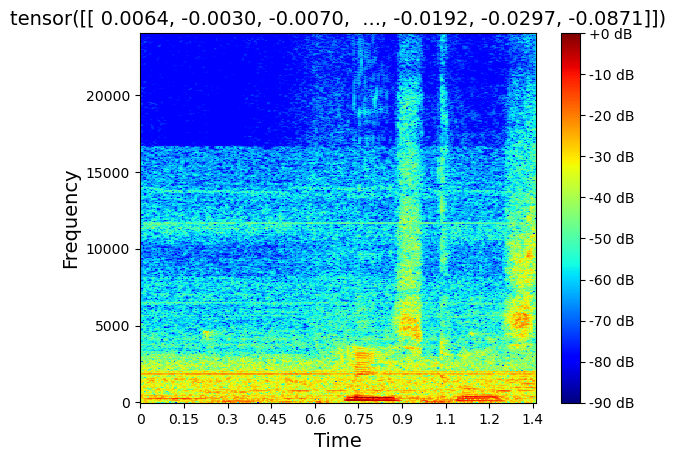

In [12]:
show_spec(noisy,noisy)
# show_spec(clean)

In [13]:
noisy = apply_lowpass_filter(noisy, dataset.cut_off, dataset.cur_order, dataset.sr)
clean = apply_lowpass_filter(clean, dataset.cut_off, dataset.cur_order, dataset.sr)

In [14]:
show_spec(noisy)
show_spec(clean)

TypeError: show_spec() missing 1 required positional argument: 'title'

In [ ]:
import torch
import librosa
import numpy as np


def ss(wav, n_fft, hop_length, num_frame=10):
    # TensorをNumPy配列に変換
    wav = wav.squeeze(0).squeeze(0).cpu().detach().numpy()
    # print(wav.shape)

    # STFTを計算してスペクトルを取得
    spectrum = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)

    # 振幅スペクトルと位相スペクトルを計算
    magnitude = np.abs(spectrum)
    phase = np.angle(spectrum)

    # ノイズスペクトルを推定（最初のnum_frameフレームの平均）
    noise_spectrum = np.mean(magnitude[:, :num_frame], axis=1, keepdims=True)

    # ゲインを計算（振幅スペクトル - ノイズスペクトル）/ 振幅スペクトル
    # 振幅スペクトルが0の場合のゼロ割りを防ぐために、εを加算
    epsilon = 1e-8
    gain = (magnitude - noise_spectrum) / (magnitude + epsilon)
    gain = np.clip(gain, 0, 1)  # ゲインを0から1の範囲に制限

    # ノイズ除去後のスペクトルを計算
    enhanced_spectrum = gain * magnitude * np.exp(1j * phase)

    # 逆STFTで時間領域信号を再構成
    enhanced_wav = librosa.istft(enhanced_spectrum, hop_length=hop_length, length=len(wav))

    # NumPy配列をTensorに変換
    enhanced_wav = torch.from_numpy(enhanced_wav).unsqueeze(0).unsqueeze(0)

    # print(enhanced_wav.shape)

    return enhanced_wav

In [ ]:
ss_noisy = ss(noisy, 512, 256)

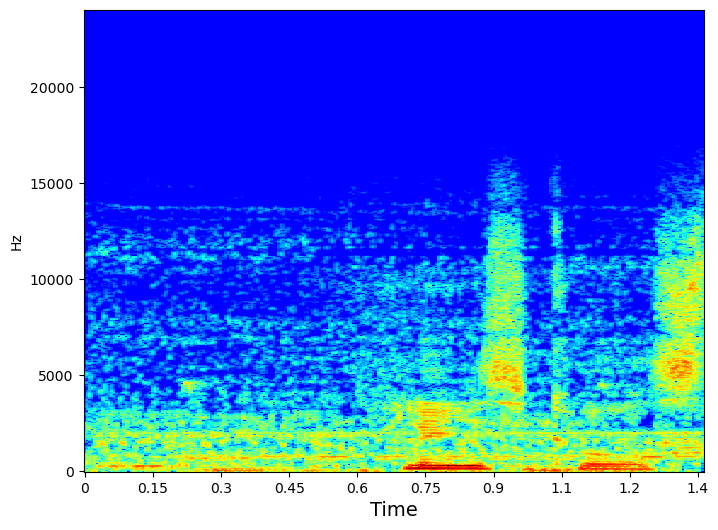

In [ ]:
show_spec(ss_noisy.squeeze(0))

In [ ]:
import torch
# mse_loss = torch.nn.MSELoss()(noisy, clean)
mse_loss = torch.nn.MSELoss()(ss_noisy.squeeze(0), ss_noisy.squeeze(0))

print(mse_loss)

tensor(0.)


In [ ]:
torchaudio.save("noisy.wav", noisy, 48000)
torchaudio.save("clean.wav", clean, 48000)